# 02 - Limpieza y Análisis Exploratorio de Datos 
### Proyecto ML: Análisis Quejas financieras  

## 📂 IMPORTACIÓN DE LIBRERÍAS

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
import re

# Configuraciones
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✅ Librerías importadas correctamente
📅 Fecha de ejecución: 2025-08-31 22:13


## 🔋 CARGA DE DATOS

In [20]:
def load_processed_data():
    """
    Carga el dataset de quejas financieras

    Parameters: 
    ----------
    file_path : str
        Ruta del archivo CSV
    
    Returns: 
    ----------
    pd.DataFrame
        Datafrme con los datos cargados
    """
    try:
        df = pd.read_csv("../data/processed/01_raw_data.csv")
        print(f"✅ Datos cargados: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"⚠️ No se encontró el archivo procesado.")
        print("💡 Asegúrate de que el archivo esté en la ruta correcta")
        return None
    except Exception as e:
        print(f"❌ Error al cargar los datos: {str(e)}")
        return None

# Cargar datos
df = load_processed_data()
print(f"📊 Dataset inicial: {df.shape[0]} filas, {df.shape[1]} columnas")

✅ Datos cargados: (28156, 13)
📊 Dataset inicial: 28156 filas, 13 columnas


## 🧹 LIMPIEZA DE DATOS

In [21]:
class DataCleaner:
    """
    Clase para limpieza sistemática de datos
    """
    
    def __init__(self, df):
        self.df = df.copy()
        self.original_shape = df.shape
        self.cleaning_log = []
    
    def log_action(self, action, details):
        """Registra las acciones de limpieza"""
        self.cleaning_log.append({
            "timestamp": datetime.now().strftime("%H:%M:%S"),
            "action": action,
            "details": details,
            "shape_after": self.df.shape
        })
        print(f"🔧 {action}: {details}")
    
    def handle_missing_values(self):
        """Manejo inteligente de valores faltantes"""
        print("\n" + "="*60)
        print("🔍 TRATAMIENTO DE VALORES FALTANTES")
        print("="*60)
        
        # Análisis inicial de valores faltantes
        missing_before = self.df.isnull().sum()
        print(f"\nValores faltantes por columna (antes):")
        for col in missing_before[missing_before > 0].index:
            pct = (missing_before[col] / len(self.df)) * 100
            print(f"   • {col}: {missing_before[col]:,} ({pct:.2f}%)")
        
        # 1. Convertir strings vacías a NaN
        self.df = self.df.replace('', np.nan)
        self.log_action("Conversión de strings vacías", "Convertidas a NaN")
        
        # 2. ZIP code: imputar con moda por estado
        if "ZIP code" in self.df.columns and 'State' in self.df.columns:
            for state in self.df["State"].dropna().unique():
                mask = (self.df["State"] == state) & (self.df['ZIP code'].isnull())
                if mask.sum() > 0:
                    mode_zip = self.df[self.df["State"] == state]['ZIP code'].mode()
                    if len(mode_zip) > 0:
                        self.df.loc[mask, "ZIP code"] = mode_zip[0]
        
        # 3. Sub-product y Sub-issue: crear categoría "Not specified"
        for col in ["Sub-product", "Sub-issue"]:
            if col in self.df.columns:
                self.df[col] = self.df[col].fillna("Not specified")
                self.log_action(f"Imputación {col}", "Valores faltantes → 'Not specified'")
        
        # 4. State: imputar con moda general o crear categoría "Unknown"
        if "State" in self.df.columns:
            self.df["State"] = self.df["State"].fillna("Unknown")
            self.log_action("Imputación State", "Valores faltantes → 'Unknown'")
        
        # 5. Consumer disputed: interpretar vacíos como "No disputed"
        if "Consumer disputed?" in self.df.columns:
            self.df["Consumer disputed?"] = self.df["Consumer disputed?"].fillna("No")
            self.log_action("Imputación Consumer disputed", "Valores faltantes → 'No'")
        
        # Análisis post-limpieza
        missing_after = self.df.isnull().sum()
        if missing_after.sum() > 0:
            print(f"\nValores faltantes restantes:")
            for col in missing_after[missing_after > 0].index:
                pct = (missing_after[col] / len(self.df)) * 100
                print(f"   • {col}: {missing_after[col]:,} ({pct:.2f}%)")
        else:
            print("\n✅ No quedan valores faltantes")
    
    def handle_duplicates(self):
        """Manejo de registros duplicados"""
        print("\n" + "="*60)
        print("🔄 TRATAMIENTO DE DUPLICADOS")
        print("="*60)
        
        initial_rows = len(self.df)
        
        # Identificar duplicados exactos
        exact_duplicates = self.df.duplicated().sum()
        print(f"Duplicados exactos encontrados: {exact_duplicates:,}")
        
        if exact_duplicates > 0:
            self.df = self.df.drop_duplicates()
            self.log_action("Eliminación de duplicados exactos", f"{exact_duplicates:,} registros eliminados")
        
        # Identificar duplicados por Complaint ID
        if "Complaint ID" in self.df.columns:
            id_duplicates = self.df["Complaint ID"].duplicated().sum()
            print(f"Duplicados por Complaint ID: {id_duplicates:,}")
            
            if id_duplicates > 0:
                self.df = self.df.drop_duplicates(subset=["Complaint ID"])
                self.log_action("Eliminación de IDs duplicados", f"{id_duplicates:,} registros eliminados")
        
        final_rows = len(self.df)
        print(f"Filas eliminadas total: {initial_rows - final_rows:,}")
    
    def clean_data_types(self):
        """Limpieza y conversión de tipos de datos"""
        print("\n" + "="*60)
        print("💿 CONVERSIÓN DE TIPOS DE DATOS")
        print("="*60)
        
        # Fechas
        date_columns = ["Date received", "Date sent to company"]
        for col in date_columns:
            if col in self.df.columns:
                self.df[col] = pd.to_datetime(self.df[col], errors="coerce")
                self.log_action(f"Conversión a datetime", f"{col}")
        
        # ZIP code a string (para preservar ceros iniciales)
        if "ZIP code" in self.df.columns:
            self.df["ZIP code"] = self.df["ZIP code"].astype(str).str.split(".").str[0]
            self.log_action("Conversión ZIP code", "A string preservando formato")
        
        # Complaint ID a string
        if "Complaint ID" in self.df.columns:
            self.df["Complaint ID"] = self.df["Complaint ID"].astype(str)
            self.log_action("Conversión Complaint ID", "A string")
        
        # Variables categóricas
        categorical_cols = ["Product", "Sub-product", "Issue", "Sub-issue", "State", 
                           "Company", "Company response", "Timely response?", "Consumer disputed?"]
        
        for col in categorical_cols:
            if col in self.df.columns:
                self.df[col] = self.df[col].astype("category")
                self.log_action(f"Conversión a categórica", f"{col}")
    
    def clean_text_data(self):
        """Limpieza de datos de texto"""
        print("\n" + "="*60)
        print("📝 LIMPIEZA DE DATOS DE TEXTO")
        print("="*60)
        
        text_columns = ["Product", "Sub-product", "Issue", "Sub-issue", "Company"]
        
        for col in text_columns:
            if col in self.df.columns:
                # Limpiar espacios extra
                self.df[col] = self.df[col].astype(str).str.strip()
                
                # Normalizar texto
                self.df[col] = self.df[col].str.title()
                
                self.log_action(f"Limpieza de texto", f"{col} - espacios y formato")
    
    def get_cleaning_summary(self):
        """Resumen de la limpieza realizada"""
        print("\n" + "="*60)
        print("📋 RESUMEN DE LIMPIEZA")
        print("="*60)
        
        print(f"Forma original: {self.original_shape}")
        print(f"Forma final: {self.df.shape}")
        print(f"Filas eliminadas: {self.original_shape[0] - self.df.shape[0]:,}")
        
        print(f"\nAcciones realizadas:")
        for i, action in enumerate(self.cleaning_log, 1):
            print(f"{i:2d}. {action['timestamp']} - {action['action']}: {action['details']}")
        
        return self.df

# Ejecutar limpieza
print("🧹 INICIANDO PROCESO DE LIMPIEZA")
cleaner = DataCleaner(df)
cleaner.handle_missing_values()
cleaner.handle_duplicates()
cleaner.clean_data_types()
cleaner.clean_text_data()
df_clean = cleaner.get_cleaning_summary()

🧹 INICIANDO PROCESO DE LIMPIEZA

🔍 TRATAMIENTO DE VALORES FALTANTES

Valores faltantes por columna (antes):
   • Sub-product: 10,574 (37.56%)
   • Issue: 2 (0.01%)
   • Sub-issue: 14,945 (53.08%)
   • State: 421 (1.50%)
   • ZIP code: 280 (0.99%)
   • Consumer disputed?: 22,150 (78.67%)
🔧 Conversión de strings vacías: Convertidas a NaN
🔧 Imputación Sub-product: Valores faltantes → 'Not specified'
🔧 Imputación Sub-issue: Valores faltantes → 'Not specified'
🔧 Imputación State: Valores faltantes → 'Unknown'
🔧 Imputación Consumer disputed: Valores faltantes → 'No'

Valores faltantes restantes:
   • Issue: 2 (0.01%)
   • ZIP code: 154 (0.55%)

🔄 TRATAMIENTO DE DUPLICADOS
Duplicados exactos encontrados: 0
Duplicados por Complaint ID: 0
Filas eliminadas total: 0

💿 CONVERSIÓN DE TIPOS DE DATOS
🔧 Conversión a datetime: Date received
🔧 Conversión a datetime: Date sent to company
🔧 Conversión ZIP code: A string preservando formato
🔧 Conversión Complaint ID: A string
🔧 Conversión a categórica: Pr

Comprobamos la limpieza de los datos mediante una parte de la función "explore_data_structure()" del notebook 01_fuentes.ipynb

In [22]:
info_data = []
for col in df_clean.columns:
    info_data.append({
        "Columna": col,
        "Tipo": str(df_clean[col].dtype),
        "No nulos": df_clean[col].count(),
        "% Nulos": round((df_clean[col].isnull().sum() / len(df_clean)) * 100, 2),
        "Valores únicos": df_clean[col].nunique()
    })

info_df = pd.DataFrame(info_data)
print(info_df.to_string(index=False))

             Columna           Tipo  No nulos  % Nulos  Valores únicos
        Complaint ID         object     28156      0.0           28156
             Product         object     28156      0.0              11
         Sub-product         object     28156      0.0              43
               Issue         object     28156      0.0              90
           Sub-issue         object     28156      0.0              47
               State       category     28156      0.0              60
            ZIP code         object     28156      0.0            9869
       Date received datetime64[ns]     28156      0.0              78
Date sent to company datetime64[ns]     28156      0.0              78
             Company         object     28156      0.0            1534
    Company response       category     28156      0.0               6
    Timely response?       category     28156      0.0               2
  Consumer disputed?       category     28156      0.0               2


## ⚒️ FEATURE ENGINEERING

In [23]:
class FeatureEngineer:
    """
    Clase para ingeniería de características
    """
    
    def __init__(self, df):
        self.df = df.copy()
        self.new_features = []
    
    def log_feature(self, feature_name, description):
        """Registra nuevas características creadas"""
        self.new_features.append({
            "feature": feature_name,
            "description": description
        })
        print(f"✨ Nueva característica: {feature_name} - {description}")
    
    def create_temporal_features(self):
        """Crear características temporales"""
        print("\n" + "="*60)
        print("📅 CREACIÓN DE CARACTERÍSTICAS TEMPORALES")
        print("="*60)
        
        if "Date received" in self.df.columns:
            # Extraer componentes de fecha
            self.df["year_received"] = self.df["Date received"].dt.year
            self.df["month_received"] = self.df["Date received"].dt.month
            self.df["dayofweek_received"] = self.df["Date received"].dt.dayofweek
            self.df["quarter_received"] = self.df["Date received"].dt.quarter
            
            # Características derivadas
            self.df["is_weekend"] = self.df["dayofweek_received"].isin([5, 6]).astype(int)
            self.df["is_holiday_season"] = self.df["month_received"].isin([11, 12]).astype(int)
            
            self.log_feature("Características temporales", "Año, mes, día, trimestre, fin de semana, temporada navideña")
        
        # Tiempo de procesamiento
        if all(col in self.df.columns for col in ["Date received", "Date sent to company"]):
            self.df["processing_days"] = (self.df["Date sent to company"] - self.df["Date received"]).dt.days
            self.df["same_day_processing"] = (self.df["processing_days"] == 0).astype(int)
            
            self.log_feature("processing_days", "Días entre recepción y envío a empresa")
            self.log_feature("same_day_processing", "Procesamiento el mismo día (binario)")
    
    def create_categorical_features(self):
        """Crear características categóricas"""
        print("\n" + "="*60)
        print("🏷️ INGENIERÍA DE CARACTERÍSTICAS CATEGÓRICAS")
        print("="*60)
        
        # Agrupar productos similares
        if "Product" in self.df.columns:
            product_mapping = {
                "debt": ["Debt Collection", "Debt Collection"],
                "credit": ["Credit Card", "Credit Reporting", "Credit Report"],
                "mortgage": ["Mortgage"],
                "banking": ["Bank Account Or Service", "Checking Or Savings Account"],
                "loan": ["Consumer Loan", "Student Loan", "Payday Loan"]
            }
            
            self.df["product_category"] = "other"
            for category, products in product_mapping.items():
                for product in products:
                    mask = self.df["Product"].str.contains(product, case=False, na=False)
                    self.df.loc[mask, "product_category"] = category
            
            self.log_feature("product_category", "Agrupación de productos en categorías principales")
        
        # Características geográficas
        if "State" in self.df.columns:
            # Regiones de EE.UU.
            regions = {
                "northeast": ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA'],
                "midwest": ['OH', 'IN', 'IL', 'MI', 'WI', 'MN', 'IA', 'MO', 'ND', 'SD', 'NE', 'KS'],
                "south": ['DE', 'MD', 'DC', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'AL', 'MS', 'AR', 'LA', 'OK', 'TX'],
                "west": ['MT', 'ID', 'WY', 'CO', 'NM', 'AZ', 'UT', 'NV', 'CA', 'OR', 'WA', 'AK', 'HI']
            }
            
            self.df["region"] = "unknown"
            for region, states in regions.items():
                self.df.loc[self.df["State"].isin(states), "region"] = region
            
            self.log_feature("region", "Región geográfica de EE.UU.")
    
    def create_aggregated_features(self):
        """Crear características agregadas"""
        print("\n" + "="*60)
        print("📊 CARACTERÍSTICAS AGREGADAS")
        print("="*60)
        
        # Frecuencia de quejas por empresa
        if "Company" in self.df.columns:
            company_counts = self.df["Company"].value_counts()
            self.df["company_complaint_count"] = self.df["Company"].map(company_counts)
            
            # Categorizar empresas por volumen de quejas
            self.df["company_size"] = pd.cut(self.df["company_complaint_count"], 
                                           bins=[0, 10, 50, 200, float("inf")], 
                                           labels=["small", "medium", "large", "enterprise"])
            
            self.log_feature("company_complaint_count", "Número total de quejas por empresa")
            self.log_feature("company_size", "Tamaño de empresa basado en volumen de quejas")
        
        # Frecuencia por estado
        if "State" in self.df.columns:
            state_counts = self.df["State"].value_counts()
            self.df["state_complaint_count"] = self.df["State"].map(state_counts)
            
            self.log_feature("state_complaint_count", "Número total de quejas por estado")
    
    def create_text_features(self):
        """Crear características basadas en texto"""
        print("\n" + "="*60)
        print("📝 CARACTERÍSTICAS DE TEXTO")
        print("="*60)
        
        # Longitud de campos de texto
        text_fields = ["Issue", "Sub-issue"]
        for field in text_fields:
            if field in self.df.columns:
                self.df[f"{field.lower()}_length"] = self.df[field].astype(str).str.len()
                self.log_feature(f"{field.lower()}_length", f"Longitud del campo {field}")
        
        # Detectar palabras clave importantes
        if "Issue" in self.df.columns:
            keywords = ["fraud", "identity", "payment", "credit", "debt", "loan"]
            for keyword in keywords:
                col_name = f'has_{keyword}'
                self.df[col_name] = self.df["Issue"].str.contains(keyword, case=False, na=False).astype(int)
                self.log_feature(col_name, f"Contiene palabra clave: {keyword}")
    
    def get_feature_summary(self):
        """Resumen de características creadas"""
        print("\n" + "="*60)
        print("📋 RESUMEN DE FEATURE ENGINEERING")
        print("="*60)
        
        print(f"Características nuevas creadas: {len(self.new_features)}")
        print(f"Dimensiones finales: {self.df.shape}")
        
        print(f"\nListado de nuevas características:")
        for i, feature in enumerate(self.new_features, 1):
            print(f"{i:2d}. {feature['feature']}: {feature['description']}")
        
        return self.df

# Ejecutar feature engineering
print("⚒️ INICIANDO FEATURE ENGINEERING")
engineer = FeatureEngineer(df_clean)
engineer.create_temporal_features()
engineer.create_categorical_features()
engineer.create_aggregated_features()
engineer.create_text_features()
df_features = engineer.get_feature_summary()

⚒️ INICIANDO FEATURE ENGINEERING

📅 CREACIÓN DE CARACTERÍSTICAS TEMPORALES
✨ Nueva característica: Características temporales - Año, mes, día, trimestre, fin de semana, temporada navideña
✨ Nueva característica: processing_days - Días entre recepción y envío a empresa
✨ Nueva característica: same_day_processing - Procesamiento el mismo día (binario)

🏷️ INGENIERÍA DE CARACTERÍSTICAS CATEGÓRICAS
✨ Nueva característica: product_category - Agrupación de productos en categorías principales
✨ Nueva característica: region - Región geográfica de EE.UU.

📊 CARACTERÍSTICAS AGREGADAS
✨ Nueva característica: company_complaint_count - Número total de quejas por empresa
✨ Nueva característica: company_size - Tamaño de empresa basado en volumen de quejas
✨ Nueva característica: state_complaint_count - Número total de quejas por estado

📝 CARACTERÍSTICAS DE TEXTO
✨ Nueva característica: issue_length - Longitud del campo Issue
✨ Nueva característica: sub-issue_length - Longitud del campo Sub-issue
✨ N

## 📊 ANÁLISIS EXPLORATORIO AVANZADO
Al final de esta sección, definiremos una función genérica que orqueste todo el análisis llamando a 5 subfunciones especializadas que iremos viendo poco a poco.  
Cada función verificará la existencia de las columnas necesarias antes de proceder, asegurándonos así haber ejecutado la limpieza y reestructuración previas correctamente.

In [24]:
# 1. Análisis de la variable objetivo

def target_analysis(df):
    """Análisis profundo de la variable objetivo"""
    print("\n📊 ANÁLISIS DE VARIABLE OBJETIVO")
    print("-" * 50)
    
    if "Company response" in df.columns:
        # Distribución de respuestas
        response_dist = df["Company response"].value_counts()
        print("Distribución de respuestas de empresa:")
        for response, count in response_dist.items():
            pct = (count / len(df)) * 100
            print(f"   • {response}: {count:,} ({pct:.1f}%)")
        
        # Crear visualización
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle("Análisis de Variable Objetivo: Company Response", fontsize=16, fontweight="bold")
        
        # 1. Distribución general
        response_dist.plot(kind="pie", ax=axes[0,0], autopct="%1.1f%%")
        axes[0,0].set_title("Distribución de Respuestas")
        axes[0,0].set_ylabel("")
        
        # 2. Por región (si existe)
        if "region" in df.columns:
            pd.crosstab(df["region"], df["Company response"]).plot(kind="bar", ax=axes[0,1])
            axes[0,1].set_title("Respuestas por Región")
            axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
            axes[0,1].tick_params(axis="x", rotation=45)
        
        # 3. Por año
        if "year_received" in df.columns:
            yearly_response = pd.crosstab(df["year_received"], df["Company response"])
            yearly_response.plot(kind="line", ax=axes[1,0], marker="o")
            axes[1,0].set_title("Tendencia de Respuestas por Año")
            axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        
        # 4. Tiempo de respuesta vs tipo
        if "Timely response?" in df.columns:
            timely_response = pd.crosstab(df["Company response"], df["Timely response?"])
            timely_response.plot(kind="bar", ax=axes[1,1])
            axes[1,1].set_title("Puntualidad por Tipo de Respuesta")
            axes[1,1].tick_params(axis="x", rotation=45)
        
        plt.tight_layout()
        plt.show()

In [25]:
# 2. Análisis temporal

def temporal_analysis(df):
    """Análisis temporal de las quejas"""
    print("\n📅 ANÁLISIS TEMPORAL")
    print("-" * 50)
    
    if "Date received" in df.columns:
        # Tendencias por año
        yearly_complaints = df.groupby("year_received").size()
        print("Quejas por año:")
        for year, count in yearly_complaints.items():
            print(f"   • {year}: {count:,}")
        
        # Visualizaciones temporales
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle("Análisis Temporal de Quejas", fontsize=16, fontweight="bold")
        
        # 1. Tendencia anual
        yearly_complaints.plot(kind="line", ax=axes[0,0], marker="o", linewidth=2)
        axes[0,0].set_title("Tendencia Anual de Quejas")
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Distribución mensual
        monthly_complaints = df.groupby("month_received").size()
        monthly_complaints.plot(kind="bar", ax=axes[0,1], color="skyblue")
        axes[0,1].set_title("Distribución Mensual")
        axes[0,1].set_xlabel("Mes")
        
        # 3. Distribución por día de la semana
        if "dayofweek_received" in df.columns:
            days = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
            dayofweek_complaints = df.groupby('dayofweek_received').size()
            dayofweek_complaints.index = days
            dayofweek_complaints.plot(kind="bar", ax=axes[1,0], color="lightcoral")
            axes[1,0].set_title("Distribución por Día de la Semana")
            axes[1,0].tick_params(axis="x", rotation=45)
        
        # 4. Tiempo de procesamiento
        if "processing_days" in df.columns:
            processing_stats = df["processing_days"].describe()
            axes[1,1].hist(df["processing_days"], bins=30, color="lightgreen", alpha=0.7)
            axes[1,1].set_title("Distribución de Días de Procesamiento")
            axes[1,1].axvline(processing_stats["mean"], color="red", linestyle="--", 
                             label=f'Media: {processing_stats["mean"]:.1f} días')
            axes[1,1].legend()
        
        plt.tight_layout()
        plt.show()

In [26]:
# 3. Análisis geográfico
    
def geographic_analysis(df):
    """Análisis geográfico"""
    print("\n🗺️ ANÁLISIS GEOGRÁFICO")
    print("-" * 50)
    
    if "State" in df.columns:
        # Top estados con más quejas
        top_states = df['State'].value_counts().head(15)
        print("Top 15 estados con más quejas:")
        for state, count in top_states.items():
            pct = (count / len(df)) * 100
            print(f"   • {state}: {count:,} ({pct:.1f}%)")
        
        # Visualizaciones geográficas
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle("Análisis Geográfico de Quejas", fontsize=16, fontweight="bold")
        
        # 1. Top 15 estados
        top_states.plot(kind="bar", ax=axes[0,0])
        axes[0,0].set_title("Top 15 Estados por Número de Quejas")
        axes[0,0].tick_params(axis="x", rotation=45)
        
        # 2. Por región
        if "region" in df.columns:
            region_complaints = df["region"].value_counts()
            region_complaints.plot(kind="pie", ax=axes[0,1], autopct='%1.1f%%')
            axes[0,1].set_title("Distribución por Región")
            axes[0,1].set_ylabel("")
        
        # 3. Heatmap: Estado vs Tipo de Respuesta
        if "Company response" in df.columns:
            state_response = pd.crosstab(df["State"], df["Company response"])
            top_10_states = df["State"].value_counts().head(10).index
            state_response_top = state_response.loc[top_10_states]
            
            sns.heatmap(state_response_top, annot=True, fmt="d", ax=axes[1,0], cmap="YlOrRd")
            axes[1,0].set_title("Heatmap: Top 10 Estados vs Tipo de Respuesta")
            axes[1,0].tick_params(axis="x", rotation=45)
        
        # 4. Quejas per capita (simulado)
        if "state_complaint_count" in df.columns:
            state_stats = df.groupby("State")["state_complaint_count"].first().sort_values(ascending=False).head(10)
            state_stats.plot(kind="bar", ax=axes[1,1], color="orange")
            axes[1,1].set_title("Top 10 Estados: Total de Quejas")
            axes[1,1].tick_params(axis="x", rotation=45)
        
        plt.tight_layout()
        plt.show()

In [27]:
# 4. Análisis de productos y empresas
    
def product_company_analysis(df):
    """Análisis de productos y empresas"""
    print("\n🏢 ANÁLISIS DE PRODUCTOS Y EMPRESAS")
    print("-" * 50)
    
    # Análisis de productos
    if "Product" in df.columns:
        top_products = df["Product"].value_counts().head(10)
        print("Top 10 productos con más quejas:")
        for product, count in top_products.items():
            pct = (count / len(df)) * 100
            print(f"   • {product}: {count:,} ({pct:.1f}%)")
    
    # Análisis de empresas
    if "Company" in df.columns:
        top_companies = df["Company"].value_counts().head(10)
        print(f"\nTop 10 empresas con más quejas:")
        for company, count in top_companies.items():
            pct = (count / len(df)) * 100
            print(f"   • {company}: {count:,} ({pct:.1f}%)")
    
    # Visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle("Análisis de Productos y Empresas", fontsize=16, fontweight="bold")
    
    # 1. Top productos
    if "Product" in df.columns:
        top_products.plot(kind="barh", ax=axes[0,0])
        axes[0,0].set_title("Top 10 Productos Más Reportados")
        axes[0,0].set_xlabel("Número de Quejas")
    
    # 2. Categorías de productos
    if "product_category" in df.columns:
        category_dist = df["product_category"].value_counts()
        category_dist.plot(kind="pie", ax=axes[0,1], autopct="%1.1f%%")
        axes[0,1].set_title("Distribución por Categoría de Producto")
        axes[0,1].set_ylabel("")
    
    # 3. Top empresas
    if "Company" in df.columns:
        top_companies.plot(kind="barh", ax=axes[1,0])
        axes[1,0].set_title("Top 10 Empresas Más Reportadas")
        axes[1,0].set_xlabel("Número de Quejas")
    
    # 4. Tamaño de empresa vs respuesta
    if all(col in df.columns for col in ["company_size", "Company response"]):
        size_response = pd.crosstab(df["company_size"], df["Company response"])
        size_response.plot(kind="bar", ax=axes[1,1])
        axes[1,1].set_title("Tamaño de Empresa vs Tipo de Respuesta")
        axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        axes[1,1].tick_params(axis="x", rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis cruzado: Producto vs Respuesta
    if all(col in df.columns for col in ['Product', 'Company response']):
        print(f"\n📊 ANÁLISIS CRUZADO: PRODUCTO VS RESPUESTA")
        product_response = pd.crosstab(df['Product'], df['Company response'], normalize='index') * 100
        
        # Mostrar solo los productos más comunes
        top_5_products = df["Product"].value_counts().head(5).index
        product_response_top = product_response.loc[top_5_products]
        
        print("Porcentaje de tipos de respuesta por producto (Top 5):")
        print(product_response_top.round(2))
        
        # Visualización del análisis cruzado
        plt.figure(figsize=(12, 8))
        sns.heatmap(product_response_top, annot=True, fmt=".1f", cmap="RdYlBu_r")
        plt.title("Heatmap: Producto vs Tipo de Respuesta (%)", fontsize=14, fontweight="bold")
        plt.ylabel("Producto")
        plt.xlabel("Tipo de Respuesta")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [28]:
# 5. Análisis de correlaciones

def correlation_analysis(df):
    """Análisis de correlaciones"""
    print("\n🔗 ANÁLISIS DE CORRELACIONES")
    print("-" * 50)
    
    # Seleccionar variables numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_cols) > 2:
        print(f"Variables numéricas encontradas: {len(numeric_cols)}")
        for col in numeric_cols[:10]:  # Mostrar solo las primeras 10
            print(f"   • {col}")
        
        # Calcular correlaciones
        corr_matrix = df[numeric_cols].corr()
        
        # Visualización de correlaciones
        plt.figure(figsize=(14, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
                   cmap="coolwarm", center=0, square=True)
        plt.title("Matriz de Correlaciones - Variables Numéricas", 
                 fontsize=14, fontweight="bold")
        plt.tight_layout()
        plt.show()
        
        # Correlaciones más fuertes
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.3:  # Solo correlaciones > 0.3
                    corr_pairs.append({
                        "var1": corr_matrix.columns[i],
                        "var2": corr_matrix.columns[j],
                        "correlation": corr_val
                    })
        
        if corr_pairs:
            print(f"\nCorrelaciones significativas (|r| > 0.3):")
            corr_df = pd.DataFrame(corr_pairs).sort_values("correlation", key=abs, ascending=False)
            for _, row in corr_df.head(10).iterrows():
                print(f"   • {row['var1']} ↔ {row['var2']}: {row['correlation']:.3f}")
    
    # Análisis de asociación para variables categóricas
    categorical_cols = ["Product", "Company response", "Timely response?", "region"]
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    
    if len(categorical_cols) >= 2:
        print(f"\n📊 ANÁLISIS DE ASOCIACIÓN - VARIABLES CATEGÓRICAS")
        
        # Chi-cuadrado entre variables categóricas importantes
        if all(col in df.columns for col in ["Product", "Company response"]):
            from scipy.stats import chi2_contingency
            
            contingency = pd.crosstab(df["Product"], df["Company response"])
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            
            print(f"Test Chi-cuadrado: Producto vs Respuesta")
            print(f"   • Chi2: {chi2:.3f}")
            print(f"   • p-value: {p_value:.6f}")
            print(f"   • Asociación: {'Significativa' if p_value < 0.05 else 'No significativa'}")

In [29]:
def advanced_eda(df):
    """
    Análisis exploratorio de datos avanzado
    """
    print("\n" + "="*80)
    print("🔍 ANÁLISIS EXPLORATORIO AVANZADO")
    print("="*80)
    
    target_analysis(df)
    
    temporal_analysis(df)
    
    geographic_analysis(df)
    
    product_company_analysis(df)
    
    correlation_analysis(df)

## 🚩 DETECCIÓN DE OUTLIERS

In [30]:
def detect_outliers(df):
    """Detección de valores atípicos"""
    print("\n" + "="*80)
    print("🔍 DETECCIÓN DE OUTLIERS")
    print("="*80)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if not numeric_cols:
        print("No se encontraron columnas numéricas para análisis de outliers")
        return df
    
    outlier_info = []
    
    for col in numeric_cols:
        if col in ["Complaint ID"]:  # Saltar IDs
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100
        
        outlier_info.append({
            "column": col,
            "outliers": outlier_count,
            "percentage": outlier_pct,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        })
    
    # Mostrar resumen de outliers
    outlier_df = pd.DataFrame(outlier_info)
    outlier_df = outlier_df[outlier_df["outliers"] > 0].sort_values("percentage", ascending=False)
    
    if len(outlier_df) > 0:
        print("Outliers detectados por columna:")
        print(outlier_df.to_string(index=False, float_format="%.2f"))
        
        # Visualizar outliers
        cols_to_plot = outlier_df.head(4)["column"].tolist()
        if cols_to_plot:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes = axes.flatten()
            fig.suptitle("Detección de Outliers - Boxplots", fontsize=16, fontweight="bold")
            
            for i, col in enumerate(cols_to_plot):
                if i < 4:
                    df.boxplot(column=col, ax=axes[i])
                    axes[i].set_title(f'{col}\n({outlier_df[outlier_df["column"]==col]["outliers"].iloc[0]} outliers)')
            
            # Ocultar subplots vacíos
            for i in range(len(cols_to_plot), 4):
                axes[i].set_visible(False)
            
            plt.tight_layout()
            plt.show()
    else:
        print("✅ No se detectaron outliers significativos")
    
    return outlier_df

## ✔️ PREPARACIÓN FINAL DE DATOS

In [31]:
def prepare_final_dataset(df):
    """Preparación final del dataset para modelado"""
    print("\n" + "="*80)
    print("🎯 PREPARACIÓN FINAL PARA MODELADO")
    print("="*80)
    
    df_final = df.copy()
    
    # Eliminar columnas no necesarias para modelado
    columns_to_drop = ["Complaint ID", "Date received", "Date sent to company"]
    columns_to_drop = [col for col in columns_to_drop if col in df_final.columns]
    
    if columns_to_drop:
        df_final = df_final.drop(columns=columns_to_drop)
        print(f"Columnas eliminadas: {columns_to_drop}")
    
    # Verificar balance de la variable objetivo
    if "Company response" in df_final.columns:
        target_distribution = df_final["Company response"].value_counts()
        print(f"\nDistribución de la variable objetivo:")
        for response, count in target_distribution.items():
            pct = (count / len(df_final)) * 100
            print(f"   • {response}: {count:,} ({pct:.1f}%)")
        
        # Calcular ratio de desbalance
        max_class = target_distribution.max()
        min_class = target_distribution.min()
        imbalance_ratio = max_class / min_class
        print(f"\nRatio de desbalance: {imbalance_ratio:.2f}")
        
        if imbalance_ratio > 2:
            print("⚠️ Dataset desbalanceado detectado - considerar técnicas de balanceo")
        else:
            print("✅ Dataset relativamente balanceado")
    
    # Resumen final
    print(f"\n📊 DATASET FINAL PARA MODELADO:")
    print(f"   • Dimensiones: {df_final.shape}")
    print(f"   • Variables numéricas: {len(df_final.select_dtypes(include=[np.number]).columns)}")
    print(f"   • Variables categóricas: {len(df_final.select_dtypes(include=['object', 'category']).columns)}")
    print(f"   • Valores faltantes: {df_final.isnull().sum().sum()}")
    
    return df_final

## 💯 Ejecución de todas las funciones de análisis


🔍 ANÁLISIS EXPLORATORIO AVANZADO

📊 ANÁLISIS DE VARIABLE OBJETIVO
--------------------------------------------------
Distribución de respuestas de empresa:
   • Closed with explanation: 19,381 (68.8%)
   • Closed with non-monetary relief: 3,593 (12.8%)
   • In progress: 2,690 (9.6%)
   • Closed with monetary relief: 1,534 (5.4%)
   • Closed: 606 (2.2%)
   • Untimely response: 352 (1.3%)


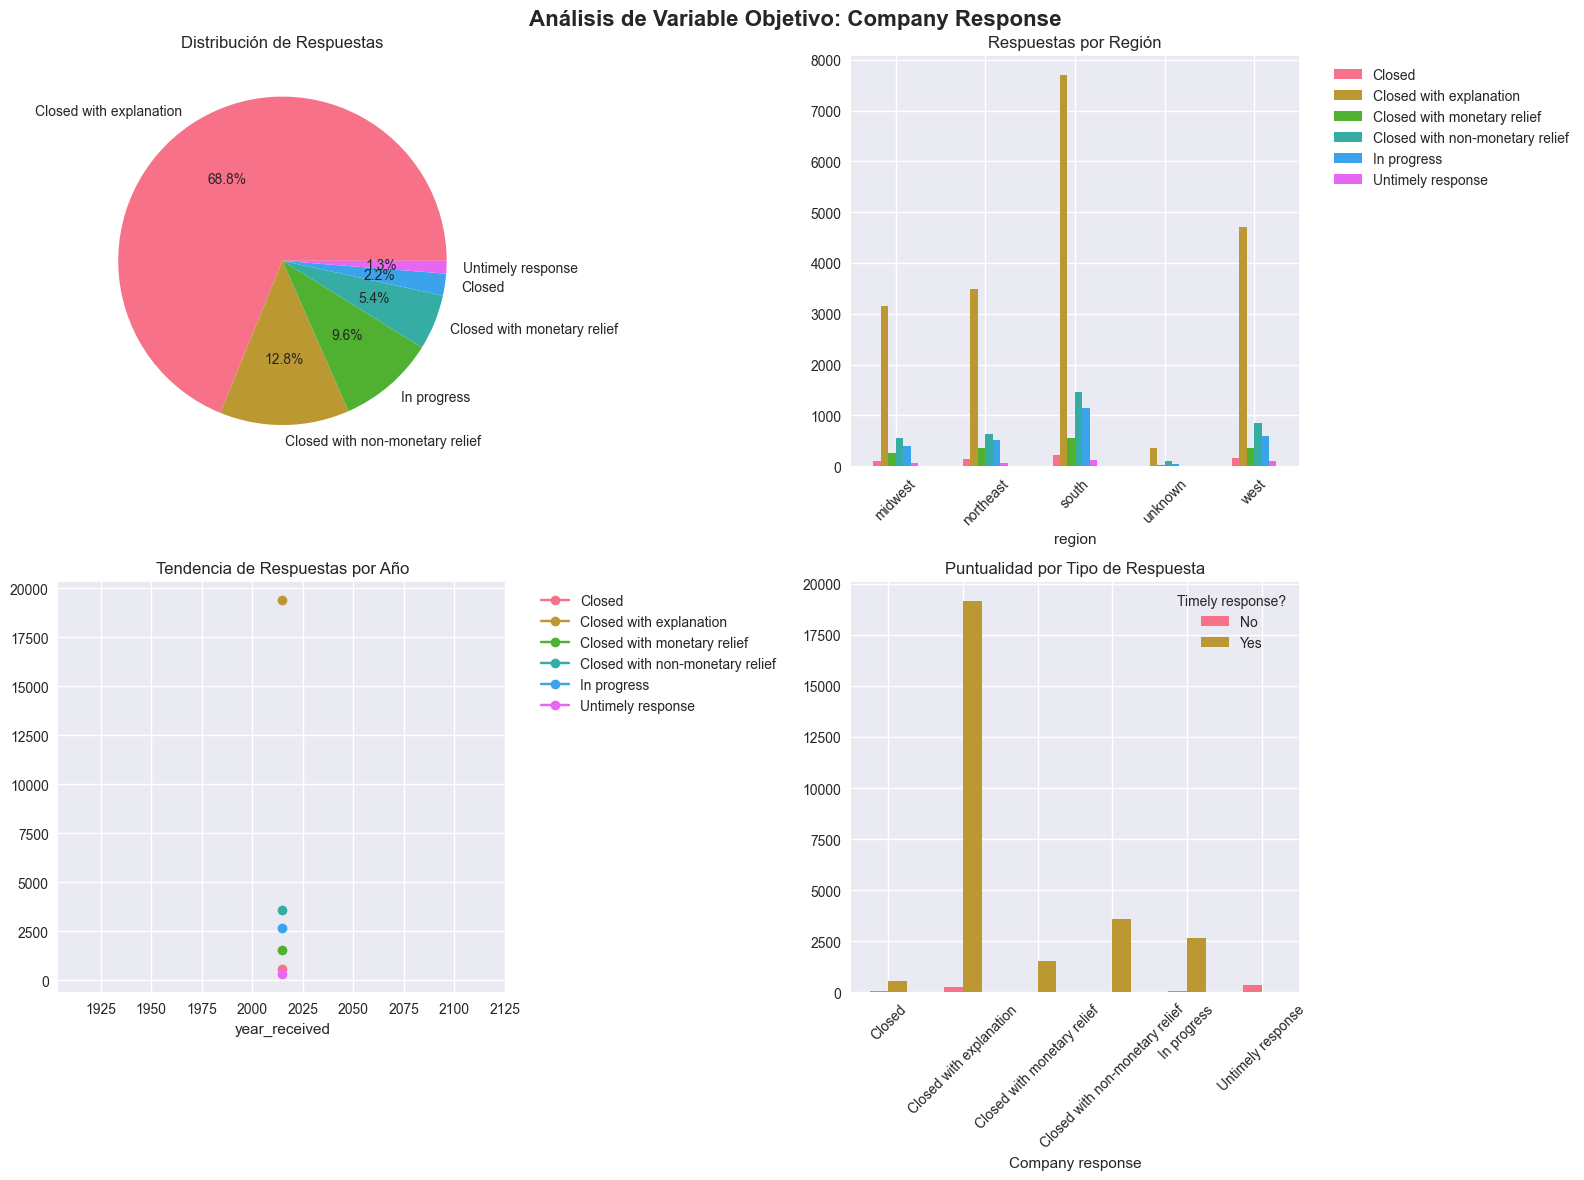


📅 ANÁLISIS TEMPORAL
--------------------------------------------------
Quejas por año:
   • 2015: 28,156


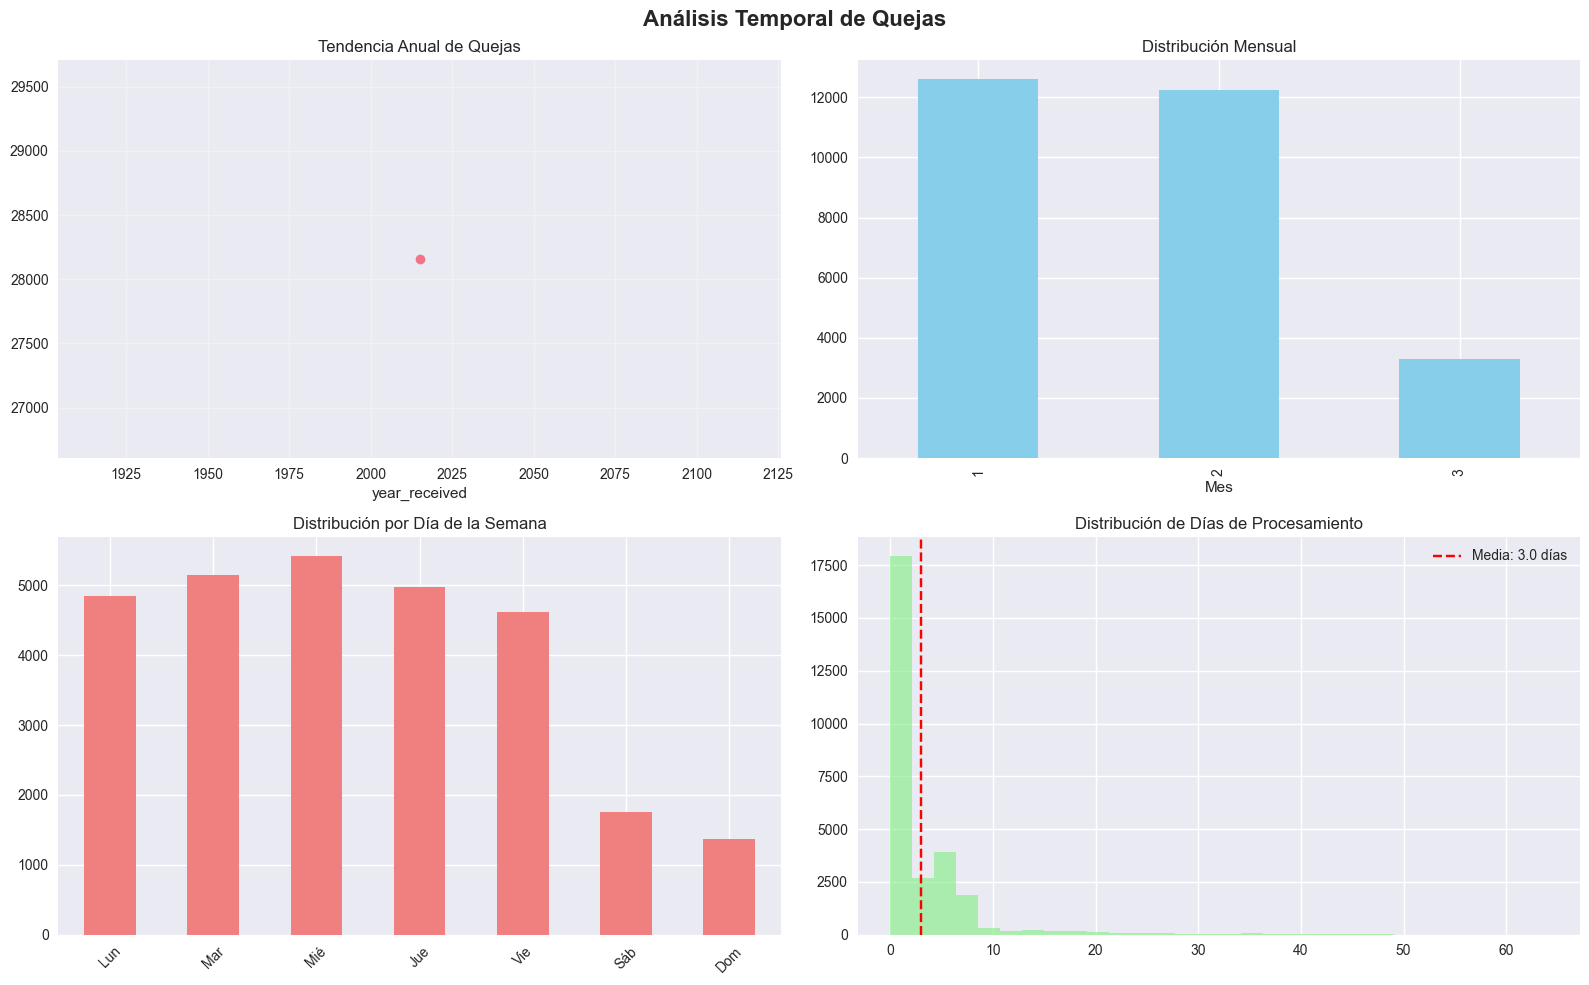


🗺️ ANÁLISIS GEOGRÁFICO
--------------------------------------------------
Top 15 estados con más quejas:
   • CA: 3,859 (13.7%)
   • FL: 2,592 (9.2%)
   • TX: 2,380 (8.5%)
   • NY: 1,846 (6.6%)
   • GA: 1,146 (4.1%)
   • NJ: 1,113 (4.0%)
   • PA: 1,055 (3.7%)
   • IL: 1,003 (3.6%)
   • OH: 939 (3.3%)
   • VA: 869 (3.1%)
   • MD: 791 (2.8%)
   • NC: 764 (2.7%)
   • MI: 694 (2.5%)
   • AZ: 578 (2.1%)
   • MA: 512 (1.8%)


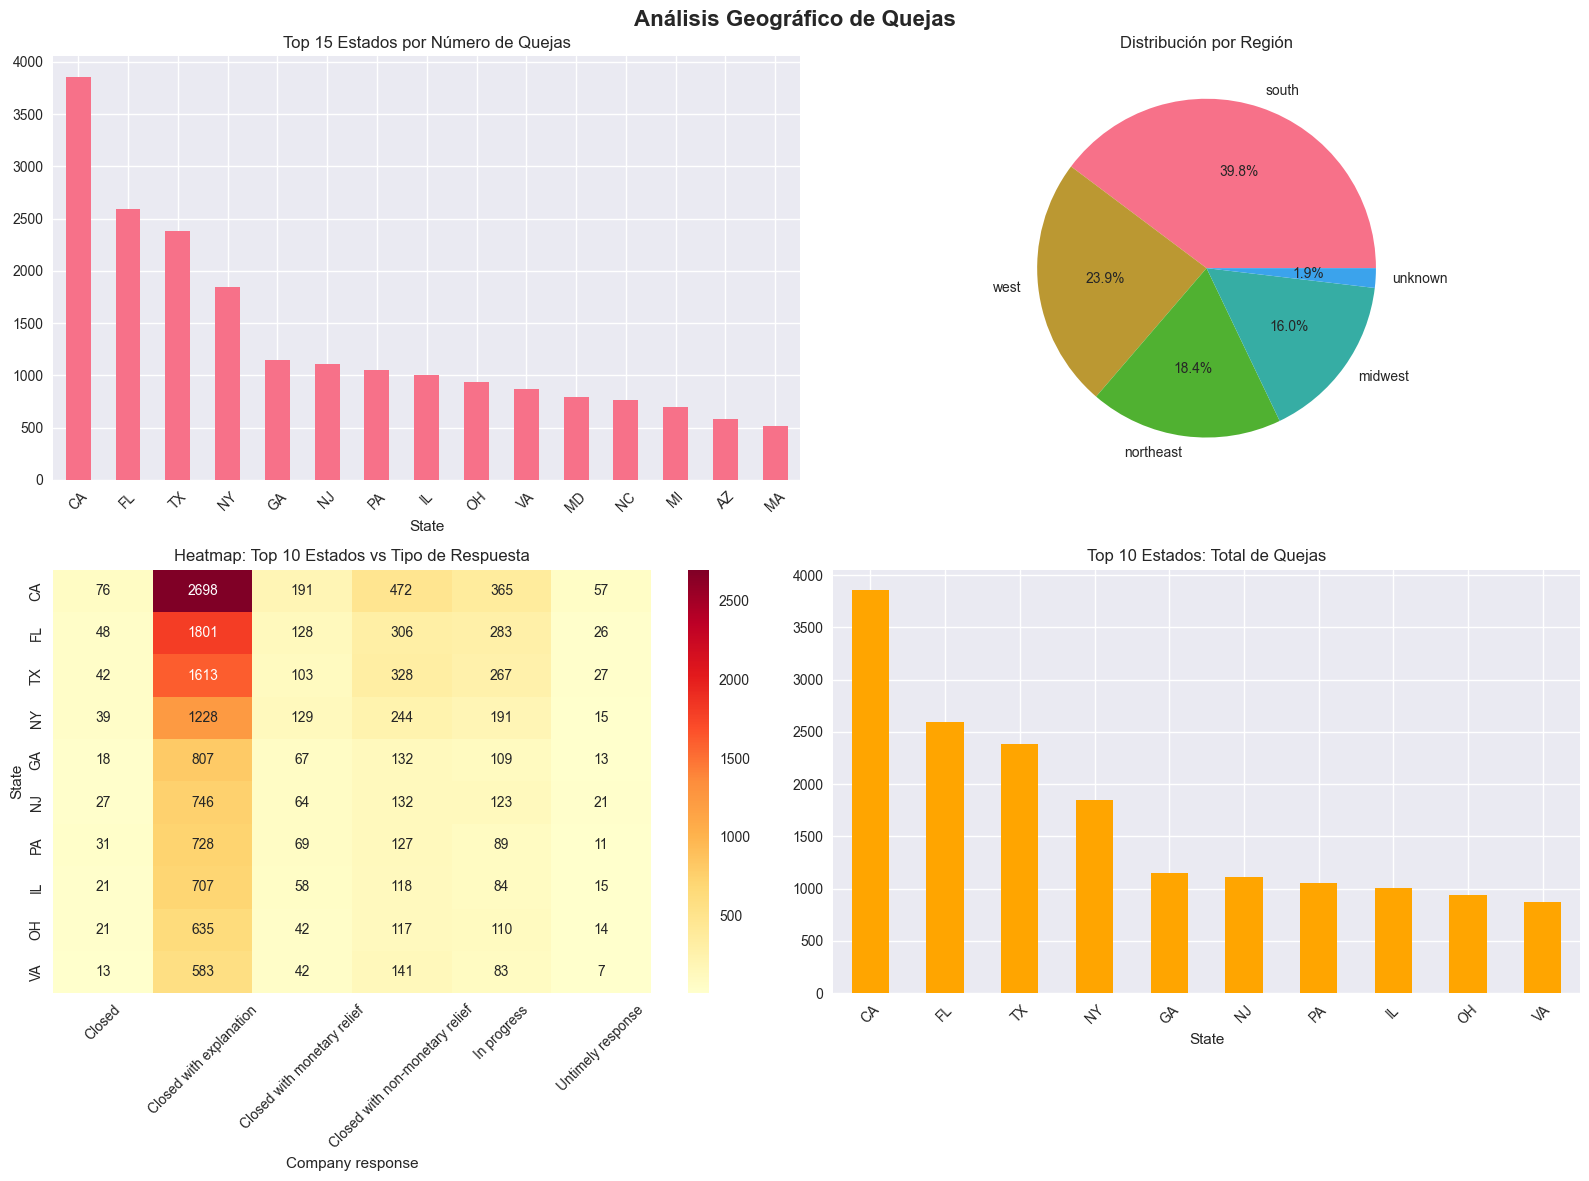


🏢 ANÁLISIS DE PRODUCTOS Y EMPRESAS
--------------------------------------------------
Top 10 productos con más quejas:
   • Debt Collection: 7,494 (26.6%)
   • Mortgage: 6,612 (23.5%)
   • Credit Reporting: 5,717 (20.3%)
   • Credit Card: 2,830 (10.1%)
   • Bank Account Or Service: 2,609 (9.3%)
   • Consumer Loan: 1,314 (4.7%)
   • Student Loan: 785 (2.8%)
   • Payday Loan: 348 (1.2%)
   • Money Transfers: 232 (0.8%)
   • Prepaid Card: 175 (0.6%)

Top 10 empresas con más quejas:
   • Equifax: 2,049 (7.3%)
   • Experian: 1,940 (6.9%)
   • Transunion: 1,525 (5.4%)
   • Bank Of America: 1,518 (5.4%)
   • Wells Fargo: 1,430 (5.1%)
   • Jpmorgan Chase: 1,272 (4.5%)
   • Citibank: 1,016 (3.6%)
   • Ocwen: 934 (3.3%)
   • Nationstar Mortgage: 749 (2.7%)
   • Capital One: 567 (2.0%)


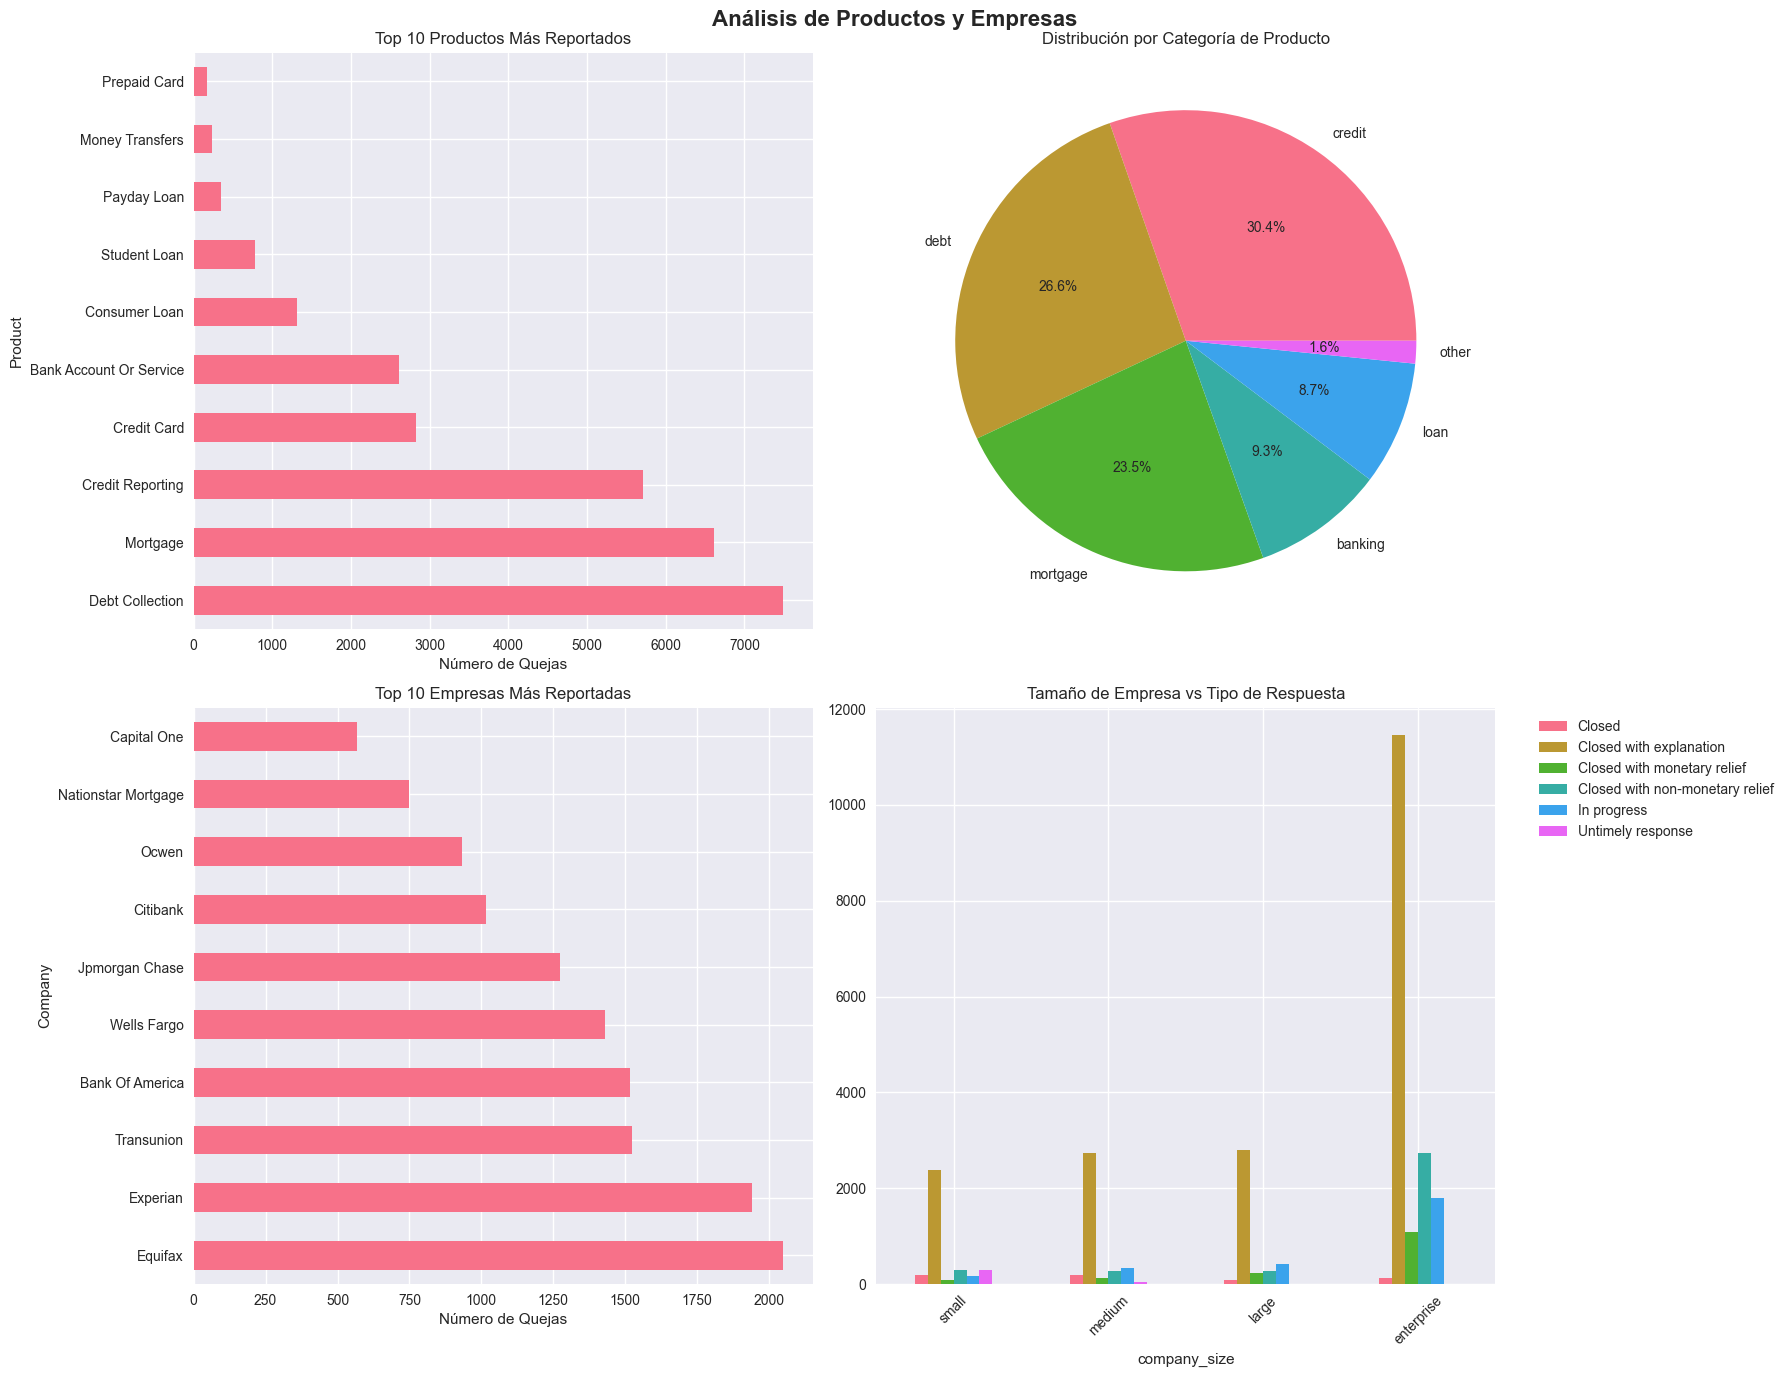


📊 ANÁLISIS CRUZADO: PRODUCTO VS RESPUESTA
Porcentaje de tipos de respuesta por producto (Top 5):
Company response         Closed  Closed with explanation  \
Product                                                    
Debt Collection            4.56                    67.36   
Mortgage                   2.13                    75.44   
Credit Reporting           0.24                    61.78   
Credit Card                0.35                    64.81   
Bank Account Or Service    2.03                    68.23   

Company response         Closed with monetary relief  \
Product                                                
Debt Collection                                 1.05   
Mortgage                                        2.54   
Credit Reporting                                0.51   
Credit Card                                    19.79   
Bank Account Or Service                        18.93   

Company response         Closed with non-monetary relief  In progress  \
Product        

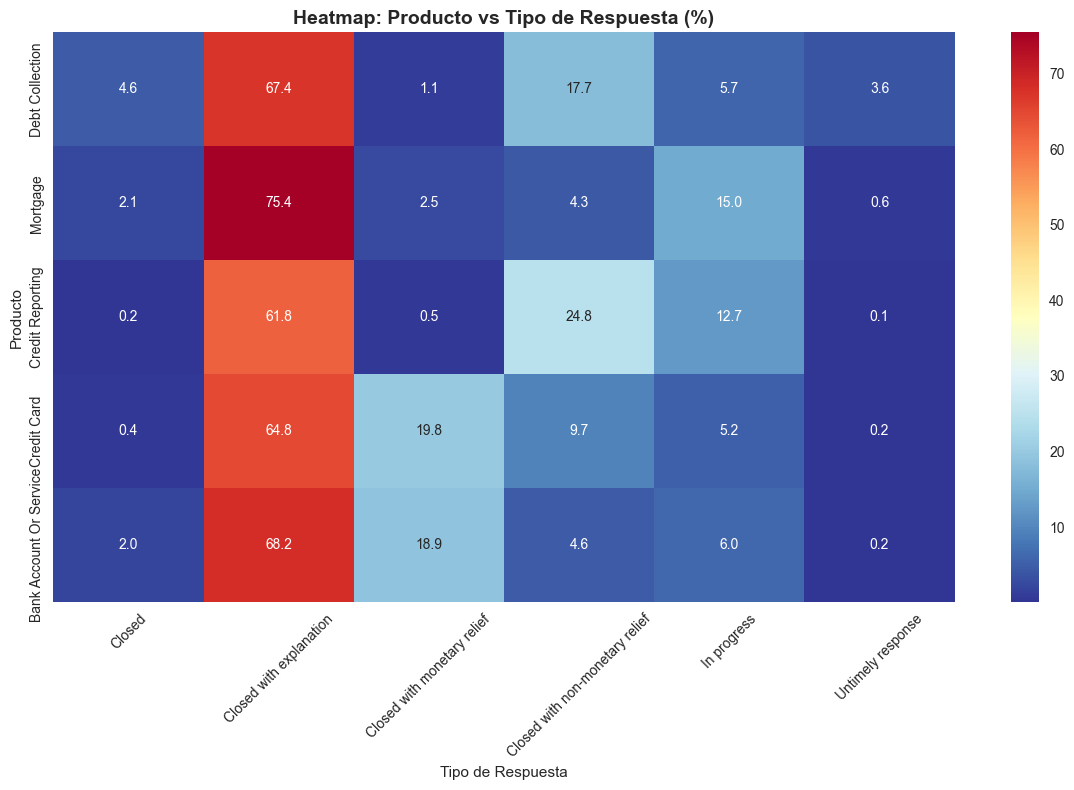


🔗 ANÁLISIS DE CORRELACIONES
--------------------------------------------------
Variables numéricas encontradas: 18
   • year_received
   • month_received
   • dayofweek_received
   • quarter_received
   • is_weekend
   • is_holiday_season
   • processing_days
   • same_day_processing
   • company_complaint_count
   • state_complaint_count


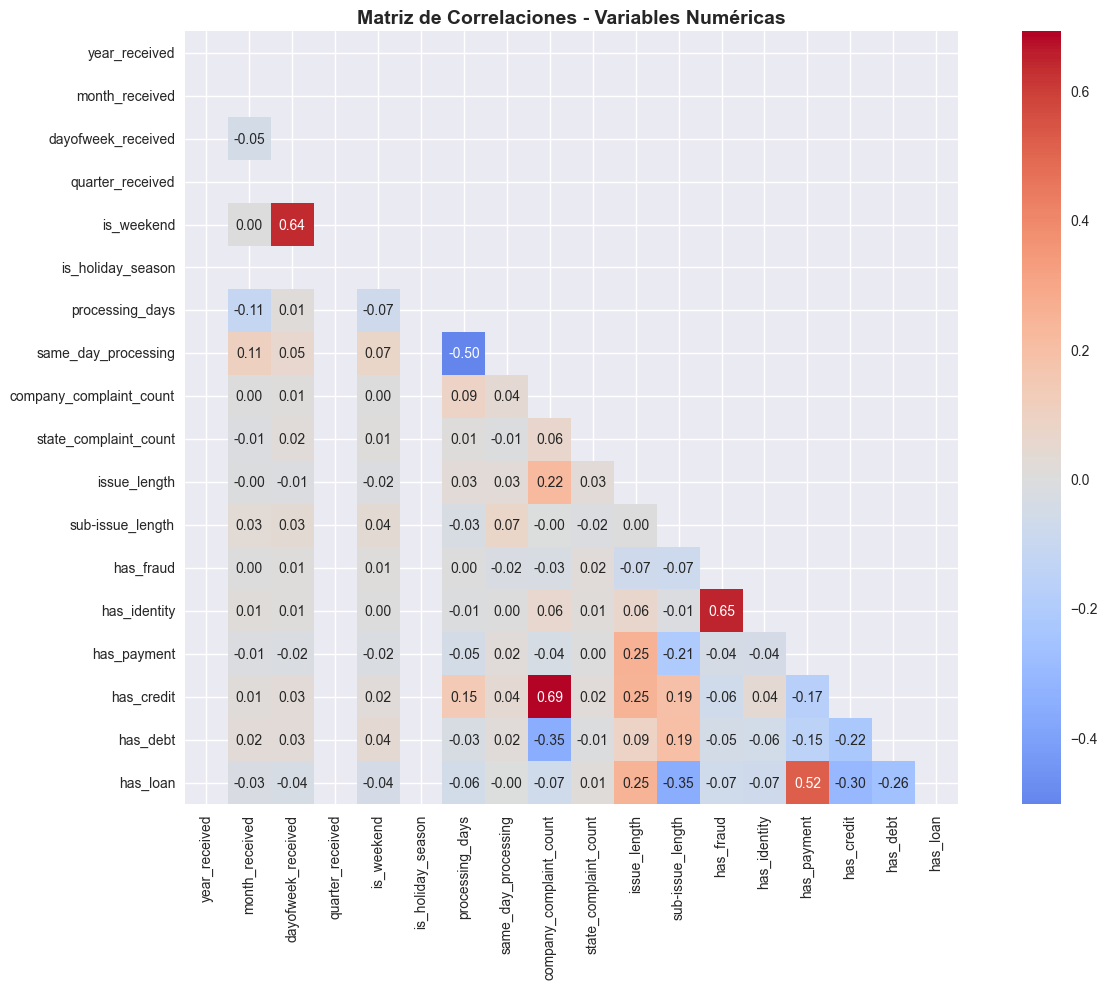


Correlaciones significativas (|r| > 0.3):
   • company_complaint_count ↔ has_credit: 0.691
   • has_fraud ↔ has_identity: 0.649
   • dayofweek_received ↔ is_weekend: 0.637
   • has_payment ↔ has_loan: 0.522
   • processing_days ↔ same_day_processing: -0.503
   • sub-issue_length ↔ has_loan: -0.352
   • company_complaint_count ↔ has_debt: -0.352
   • has_credit ↔ has_loan: -0.304

📊 ANÁLISIS DE ASOCIACIÓN - VARIABLES CATEGÓRICAS
Test Chi-cuadrado: Producto vs Respuesta
   • Chi2: 5680.479
   • p-value: 0.000000
   • Asociación: Significativa

🔍 DETECCIÓN DE OUTLIERS
Outliers detectados por columna:
          column  outliers  percentage  lower_bound  upper_bound
        has_loan      6902       24.51         0.00         0.00
      has_credit      6252       22.20         0.00         0.00
        has_debt      4739       16.83         0.00         0.00
      is_weekend      3130       11.12         0.00         0.00
     has_payment      2891       10.27         0.00         0.00
    

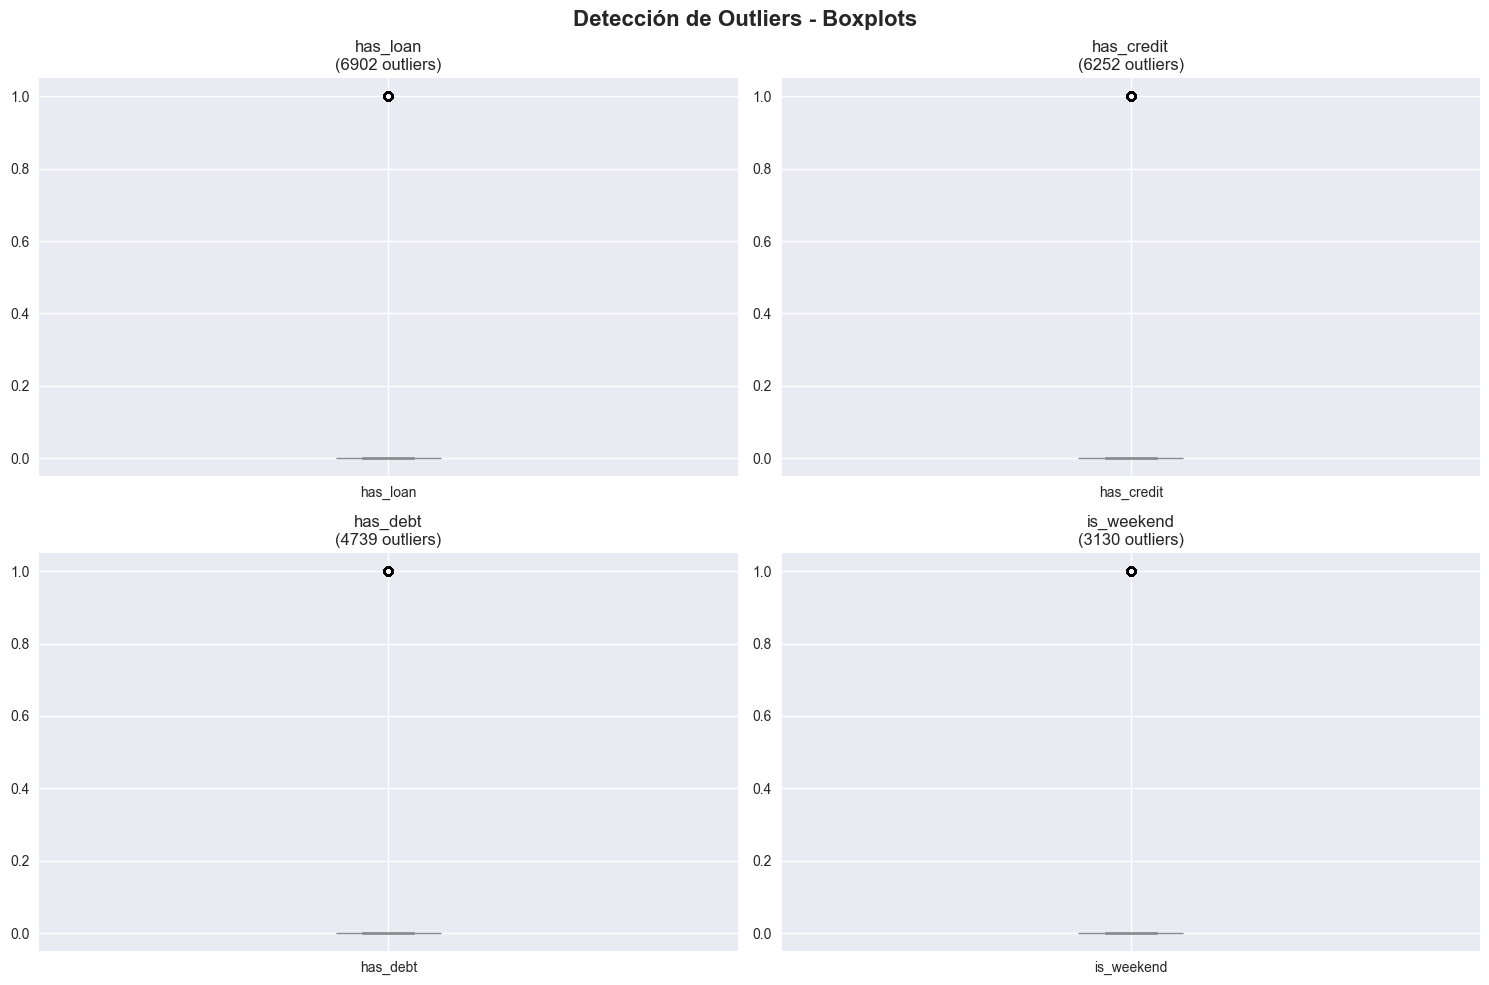


🎯 PREPARACIÓN FINAL PARA MODELADO
Columnas eliminadas: ['Complaint ID', 'Date received', 'Date sent to company']

Distribución de la variable objetivo:
   • Closed with explanation: 19,381 (68.8%)
   • Closed with non-monetary relief: 3,593 (12.8%)
   • In progress: 2,690 (9.6%)
   • Closed with monetary relief: 1,534 (5.4%)
   • Closed: 606 (2.2%)
   • Untimely response: 352 (1.3%)

Ratio de desbalance: 55.06
⚠️ Dataset desbalanceado detectado - considerar técnicas de balanceo

📊 DATASET FINAL PARA MODELADO:
   • Dimensiones: (28156, 31)
   • Variables numéricas: 18
   • Variables categóricas: 13
   • Valores faltantes: 0


In [32]:
advanced_eda(df_features)
outlier_info = detect_outliers(df_features)
df_final = prepare_final_dataset(df_features)

## 📘 RESUMEN 

In [33]:
print("\n" + "="*80)
print("🎉 LIMPIEZA Y EDA COMPLETADOS EXITOSAMENTE")
print("="*80)

print(f"\n📋 RESUMEN DE TRANSFORMACIONES:")
print(f"   ✅ Limpieza de datos realizada")
print(f"   ✅ {len(df_features.columns) - len(df_clean.columns)} nuevas características creadas")
print(f"   ✅ Análisis exploratorio avanzado completado")
print(f"   ✅ Detección de outliers realizada")
print(f"   ✅ Dataset preparado para modelado")

print(f"\n📊 ESTADÍSTICAS FINALES:")
print(f"   • Dataset final: {df_final.shape[0]:,} filas x {df_final.shape[1]} columnas")
print(f"   • Variables numéricas: {len(df_final.select_dtypes(include=[np.number]).columns)}")
print(f"   • Variables categóricas: {len(df_final.select_dtypes(include=['object', 'category']).columns)}")
print(f"   • Calidad de datos: {((df_final.shape[0] * df_final.shape[1] - df_final.isnull().sum().sum()) / (df_final.shape[0] * df_final.shape[1]) * 100):.1f}% completo")

if "Company response" in df_final.columns:
    target_balance = df_final["Company response"].value_counts()
    imbalance = target_balance.max() / target_balance.min()
    print(f"   • Balance objetivo: Ratio {imbalance:.2f} ({'Desbalanceado' if imbalance > 2 else 'Balanceado'})")

print(f"\n🔍 INSIGHTS PRINCIPALES:")
if "Product" in df_final.columns:
    top_product = df_final["Product"].mode()[0]
    print(f"   • Producto más problemático: {top_product}")

if "State" in df_final.columns:
    top_state = df_final["State"].mode()[0]
    print(f"   • Estado con más quejas: {top_state}")

if "processing_days" in df_final.columns:
    avg_processing = df_final["processing_days"].mean()
    print(f"   • Tiempo promedio de procesamiento: {avg_processing:.1f} días")



🎉 LIMPIEZA Y EDA COMPLETADOS EXITOSAMENTE

📋 RESUMEN DE TRANSFORMACIONES:
   ✅ Limpieza de datos realizada
   ✅ 21 nuevas características creadas
   ✅ Análisis exploratorio avanzado completado
   ✅ Detección de outliers realizada
   ✅ Dataset preparado para modelado

📊 ESTADÍSTICAS FINALES:
   • Dataset final: 28,156 filas x 31 columnas
   • Variables numéricas: 18
   • Variables categóricas: 13
   • Calidad de datos: 100.0% completo
   • Balance objetivo: Ratio 55.06 (Desbalanceado)

🔍 INSIGHTS PRINCIPALES:
   • Producto más problemático: Debt Collection
   • Estado con más quejas: CA
   • Tiempo promedio de procesamiento: 3.0 días


## 💾 GUARDAR RESULTADOS

In [34]:
def save_eda_results(df_clean, df_features, df_final, outlier_info):
    """Guardar todos los resultados del EDA"""
    print("💾 GUARDANDO RESULTADOS")
    
    # Crear directorios
    import os
    os.makedirs("../data/processed", exist_ok=True)
    os.makedirs("../reports", exist_ok=True)
    
    # Guardar datasets
    df_clean.to_csv("../data/processed/02_cleaned_data.csv", index=False)
    df_features.to_csv("../data/processed/02_featured_data.csv", index=False)
    df_final.to_csv("../data/processed/02_final_data.csv", index=False)
    
    # Guardar reportes
    if len(outlier_info) > 0:
        outlier_info.to_csv("../reports/02_outlier_analysis.csv", index=False)
    
    # Crear reporte de resumen
    summary_report = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "original_shape": df_clean.shape,
        "final_shape": df_final.shape,
        "features_created": len(df_features.columns) - len(df_clean.columns),
        "outliers_detected": len(outlier_info) if len(outlier_info) > 0 else 0,
        "missing_values_final": df_final.isnull().sum().sum(),
        "target_variable": "Company response",
        "target_classes": df_final["Company response"].nunique() if "Company response" in df_final.columns else "N/A"
    }
    
    summary_df = pd.DataFrame([summary_report])
    summary_df.to_csv("../reports/02_eda_summary.csv", index=False)

# Guardar todos los resultados
save_eda_results(df_clean, df_features, df_final, outlier_info)

💾 GUARDANDO RESULTADOS


## ✅ PRÓXIMOS PASOS EN MENTE: 
1. Continuar con 03_Entrenamiento_Evaluacion.ipynb
2. Implementar y comparar múltiples modelos de ML
3. Optimizar hiperparámetros del mejor modelo  
  

## ⚠️ CONSIDERACIONES PARA MODELADO:
- Revisar necesidad de balanceo de clases
- Considerar feature selection si hay muchas variables
- Evaluar necesidad de normalización/estandarización
- Definir estrategia de validación cruzada